t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets, e.g. Gene Expression Datasets. 

t-SNE measures the distance from each data-instance to every other instance, converted into a probability by fitting a normal distribution over the current case. These probabilities are scaled by dividing them by their sum, so that they add to 1 (a standard practice to convert an array of natural numbers to probabilities.)

<img src="./figs/t-sne-fig1.png" width="700">

This is done for each data instance.

When converting these distances in the lower-dimensional representation into probabilities, t-SNE fits a Student’s t distribution over the current data-instance instead of a normal distribution. The Student’s t distribution has longer tails, meaning dissimilar cases are pushed further away to achieve the same probability as in the high-dimensional representation. This allows a very strict neighbour (local) structure to prevail in the t-SNE embedding space.

<img src="./figs/t-sne-fig2.png" width="700">

The goal is then to force a match between the Gaussian distribution (in the original space) and the t-distribution (in the t-SNE embedding space). This is done minimising a loss function: The [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence). This is an iterative procedure and requires a parameter called "Maximum number of steps" ($n_{iter}$ in Scikit-Learn version of t-SNE).

There are some more hyperparameters, such as $perplexity$ value that roughly translates to the data density in the neighbourhood of a data-instance. I have discussed about this in our zoom discussion. Please go through it. In fact, you can see how this parameter affects the t-SNE performance through the experiments in this notebook.

In [51]:
#load all the required libraries
import time
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
#load the gene-expression matrix
data_path = './data/GSE135304-GPL10558-expr.txt'
#data_path = './data/GSE182719-GPL15103-expr.txt'
df = pd.read_csv(f'{data_path}', delimiter='\t')
df.shape

(48107, 714)

In [53]:
#let's print how the data looks like: Samples are in columns and genes are in rows
df.head()

,ArrayId,Name,GSM4003137,GSM4003138,GSM4003139,GSM4003140,GSM4003141,GSM4003142,GSM4003143,GSM4003144,...,GSM4003839,GSM4003840,GSM4003841,GSM4003842,GSM4003843,GSM4003844,GSM4003845,GSM4003846,GSM4003847,GSM4003848
0,ILMN_1343048,None,16.093883,16.028732,16.053174,16.047121,16.122106,16.082247,16.126613,16.060277,...,16.086952,16.094936,16.131340,16.092288,16.048631,16.064528,16.072429,16.058458,16.088361,16.089338
1,ILMN_1343049,None,16.039603,16.096571,15.918125,15.962915,15.964360,15.953828,16.133194,15.943916,...,16.093942,16.060551,16.110846,16.095972,16.106861,16.102535,16.093284,16.077883,16.096129,16.086283
2,ILMN_1343050,None,12.398912,12.249860,12.202649,12.039583,12.204399,12.023314,12.084878,12.248695,...,11.864123,12.575259,12.639629,11.667187,13.084922,13.168923,13.105749,13.048962,12.997640,13.185869
3,ILMN_1343052,None,12.455346,12.132988,12.336385,12.296461,12.382334,12.396480,12.165941,12.383153,...,12.043684,12.602236,12.672080,12.007531,13.243417,13.135886,13.236455,13.215200,13.112443,13.225422
4,ILMN_1343059,None,7.488336,7.491862,7.219850,7.245735,7.259957,7.538343,7.408499,7.262833,...,7.718560,9.443925,9.553463,7.775468,8.001818,8.285483,8.132398,8.156103,7.912965,8.029610


In [54]:
#extract out the gene-expression matrix (ignore the gene names, etc.)
if 'ArrayId' in df.columns:
    df = df.drop(columns=['ArrayId','Name'])
if 'ProbeID' in df.columns:
    df = df.drop(columns=['ProbeID','Name'])
#you can add more condition based on your column name
df.shape

(48107, 712)

In [55]:
#each sample must be represented by a gene-expression vectorm, so:
df_t = df.T 
df_t.head()

,0,1,2,3,4,5,6,7,8,9,...,48097,48098,48099,48100,48101,48102,48103,48104,48105,48106
GSM4003137,16.093883,16.039603,12.398912,12.455346,7.488336,13.967956,15.007267,8.624188,11.065228,15.661488,...,8.013607,7.594869,7.672662,7.580116,8.163861,7.585748,7.732652,7.830685,7.649053,8.405385
GSM4003138,16.028732,16.096571,12.249860,12.132988,7.491862,13.808674,14.890788,8.568161,11.013411,15.895257,...,7.586588,7.480797,7.799060,7.771620,8.277465,7.556695,7.649816,7.517236,7.644866,8.186260
GSM4003139,16.053174,15.918125,12.202649,12.336385,7.219850,13.703582,14.728557,8.395320,10.947691,15.623029,...,7.538582,7.406923,7.643387,7.596966,8.231074,7.423594,7.474865,7.594864,7.660447,7.882570
GSM4003140,16.047121,15.962915,12.039583,12.296461,7.245735,13.579091,14.485575,8.464262,10.597015,15.264337,...,7.397437,7.453892,7.603289,7.337004,8.161384,7.500950,7.335321,7.526793,7.407632,7.855430
GSM4003141,16.122106,15.964360,12.204399,12.382334,7.259957,13.908136,15.018289,8.626500,10.950315,15.129723,...,7.265248,7.551611,7.742446,7.588443,8.112634,7.538731,7.852475,7.642652,7.876422,7.935854


Notice that each sample is represented by a `df_t.shape[1]` vector (e.g. 48106-length real valued vector; or we can say $\mathbf{x} \in \mathbb{R}^{48106}$).

We are interested in represent each sample in a lower-dimensional space (human visualisable: 2-dimension). We will use the t-Stochastic Neighbour Embedding (t-SNE) to do this job for us. See the associated notebook/slides/notes in this repository.


In [56]:
#t-SNE and see how much time it takes
time_start = time.time()

tsne = TSNE(n_components=2,
            init='random',
            verbose=2, 
            perplexity=10, 
            n_iter=1000,
            learning_rate='auto',
            random_state=0)

tsne_results = tsne.fit_transform(df_t)

print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds.')

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 712 samples in 0.037s...
[t-SNE] Computed neighbors for 712 samples in 0.426s...
[t-SNE] Computed conditional probabilities for sample 712 / 712
[t-SNE] Mean sigma: 19.501077
[t-SNE] Computed conditional probabilities in 0.020s
[t-SNE] Iteration 50: error = 75.8117523, gradient norm = 0.1205472 (50 iterations in 0.492s)
[t-SNE] Iteration 100: error = 65.7448807, gradient norm = 0.0467441 (50 iterations in 0.419s)
[t-SNE] Iteration 150: error = 64.6695175, gradient norm = 0.0199261 (50 iterations in 0.595s)
[t-SNE] Iteration 200: error = 64.3346634, gradient norm = 0.0324021 (50 iterations in 0.518s)
[t-SNE] Iteration 250: error = 64.1775208, gradient norm = 0.0118302 (50 iterations in 0.588s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.177521
[t-SNE] Iteration 300: error = 1.1638697, gradient norm = 0.0019598 (50 iterations in 0.582s)
[t-SNE] Iteration 350: error = 0.9337384, gradient norm = 0.0007569 

<AxesSubplot:xlabel='var1', ylabel='var2'>

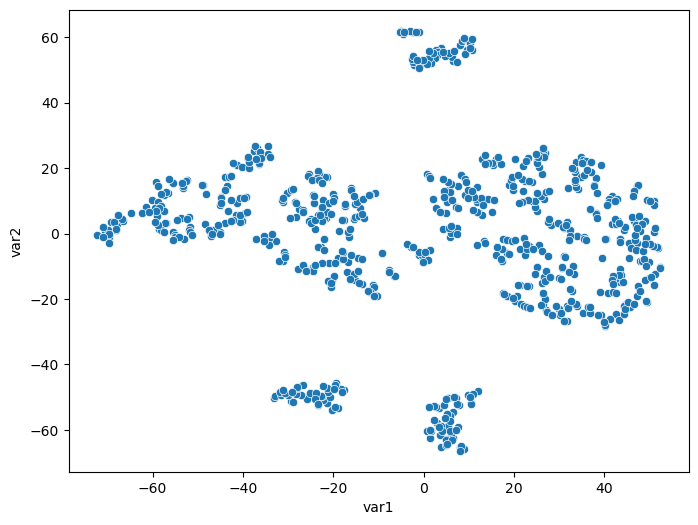

In [57]:
#visualise the result in low-dimension (2-dim)
tsne_embedding = pd.DataFrame()
tsne_embedding['var1'] = tsne_results[:,0]
tsne_embedding['var2'] = tsne_results[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="var1", y="var2",
    palette=sns.color_palette("hls", 10),
    data=tsne_embedding,
    legend="full",
    alpha=1
)

One would agree that the standard Euclidean distance in such a high-dimensional space ($\mathbb{R}^{48106}$) doesn't work well (see Wiki page on [Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)). So, to make things meaningful, let's try reducing the dimension to a lower dimension first, using [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and then learn t-SNE on the reduced dimension. See below:

In [58]:
#t-SNE and see how much time it takes
time_start = time.time()

tsne = TSNE(n_components=2,
            init='pca',
            verbose=2, 
            perplexity=10, 
            n_iter=1000,
            learning_rate='auto',
            random_state=0)

tsne_results = tsne.fit_transform(df_t)

print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds.')

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 712 samples in 0.041s...
[t-SNE] Computed neighbors for 712 samples in 0.484s...
[t-SNE] Computed conditional probabilities for sample 712 / 712
[t-SNE] Mean sigma: 19.501077
[t-SNE] Computed conditional probabilities in 0.021s


/home/dash/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 58.0842819, gradient norm = 0.1324442 (50 iterations in 0.456s)
[t-SNE] Iteration 100: error = 57.7614441, gradient norm = 0.0936030 (50 iterations in 0.541s)
[t-SNE] Iteration 150: error = 57.5847511, gradient norm = 0.1278501 (50 iterations in 0.318s)
[t-SNE] Iteration 200: error = 58.4560776, gradient norm = 0.0798055 (50 iterations in 0.333s)
[t-SNE] Iteration 250: error = 57.8833656, gradient norm = 0.0846641 (50 iterations in 0.301s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.883366
[t-SNE] Iteration 300: error = 0.9242509, gradient norm = 0.0014398 (50 iterations in 0.365s)
[t-SNE] Iteration 350: error = 0.8612249, gradient norm = 0.0005573 (50 iterations in 0.491s)
[t-SNE] Iteration 400: error = 0.8254696, gradient norm = 0.0004457 (50 iterations in 0.364s)
[t-SNE] Iteration 450: error = 0.7973323, gradient norm = 0.0003973 (50 iterations in 0.416s)
[t-SNE] Iteration 500: error = 0.7809603, gradient norm = 0.0002218 (50 

<AxesSubplot:xlabel='var1', ylabel='var2'>

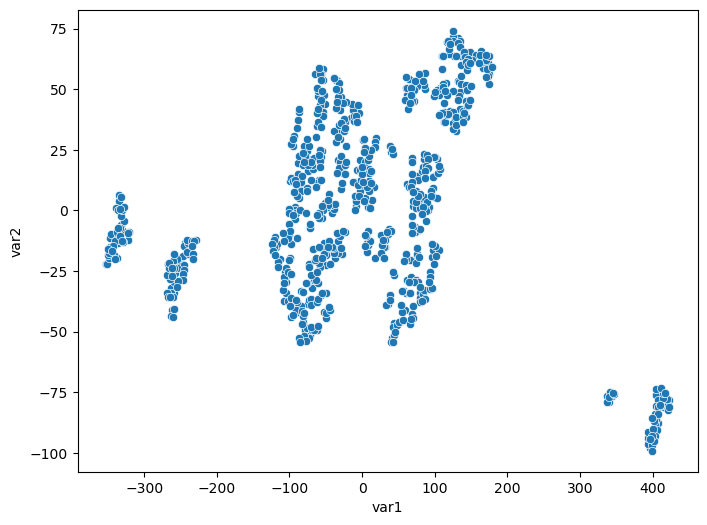

In [59]:
#visualise the result in low-dimension (2-dim)
tsne_embedding = pd.DataFrame()
tsne_embedding['var1'] = tsne_results[:,0]
tsne_embedding['var2'] = tsne_results[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="var1", y="var2",
    palette=sns.color_palette("hls", 10),
    data=tsne_embedding,
    legend="full",
    alpha=1
)

There is some difference to the earlier results.

Now, we want to see how the various hyperparameters have effect on the t-SNE results.

**Effect of Hyperparameters:**

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 712 samples in 0.040s...
[t-SNE] Computed neighbors for 712 samples in 0.513s...
[t-SNE] Computed conditional probabilities for sample 712 / 712
[t-SNE] Mean sigma: 23.949893
[t-SNE] Computed conditional probabilities in 0.052s


/home/dash/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 59.9521866, gradient norm = 0.1157193 (50 iterations in 0.419s)
[t-SNE] Iteration 100: error = 59.5505219, gradient norm = 0.0846624 (50 iterations in 0.317s)
[t-SNE] Iteration 150: error = 59.2691002, gradient norm = 0.0747011 (50 iterations in 0.304s)
[t-SNE] Iteration 200: error = 59.0055618, gradient norm = 0.0719339 (50 iterations in 0.288s)
[t-SNE] Iteration 250: error = 58.6204224, gradient norm = 0.0678523 (50 iterations in 0.274s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.620422
[t-SNE] Iteration 300: error = 0.8655559, gradient norm = 0.0015140 (50 iterations in 0.351s)
[t-SNE] Iteration 350: error = 0.7762856, gradient norm = 0.0006640 (50 iterations in 0.317s)
[t-SNE] Iteration 400: error = 0.7415856, gradient norm = 0.0003173 (50 iterations in 0.335s)
[t-SNE] Iteration 450: error = 0.7263185, gradient norm = 0.0002634 (50 iterations in 0.362s)
[t-SNE] Iteration 500: error = 0.7096760, gradient norm = 0.0002589 (50 

<AxesSubplot:xlabel='var1', ylabel='var2'>

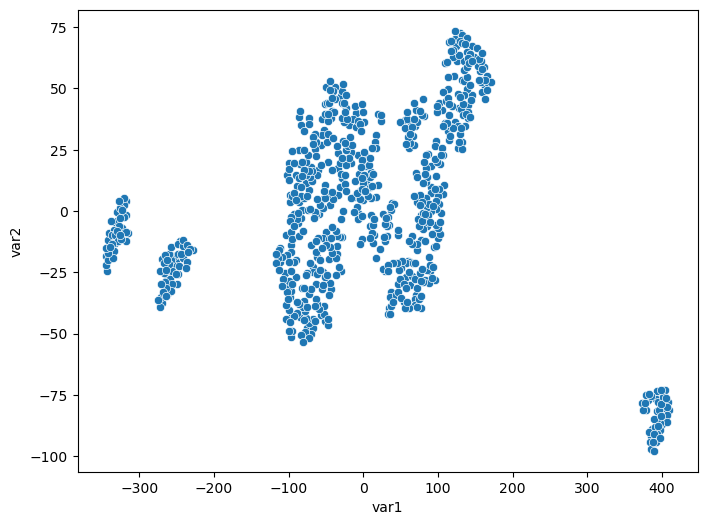

In [60]:
#t-SNE and see how much time it takes (Perplexity=20)
time_start = time.time()

tsne = TSNE(n_components=2,
            init='pca',
            verbose=2, 
            perplexity=20, 
            n_iter=1000,
            learning_rate='auto',
            random_state=0)

tsne_results = tsne.fit_transform(df_t)

print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds.')

#visualise the result in low-dimension (2-dim)
tsne_embedding = pd.DataFrame()
tsne_embedding['var1'] = tsne_results[:,0]
tsne_embedding['var2'] = tsne_results[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="var1", y="var2",
    palette=sns.color_palette("hls", 10),
    data=tsne_embedding,
    legend="full",
    alpha=1
)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 712 samples in 0.040s...
[t-SNE] Computed neighbors for 712 samples in 0.500s...
[t-SNE] Computed conditional probabilities for sample 712 / 712
[t-SNE] Mean sigma: 31.708953
[t-SNE] Computed conditional probabilities in 0.101s


/home/dash/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Iteration 50: error = 64.5999832, gradient norm = 0.1126064 (50 iterations in 0.600s)
[t-SNE] Iteration 100: error = 62.2042236, gradient norm = 0.0598005 (50 iterations in 0.731s)
[t-SNE] Iteration 150: error = 58.9448738, gradient norm = 0.0580516 (50 iterations in 0.595s)
[t-SNE] Iteration 200: error = 57.9971275, gradient norm = 0.0608441 (50 iterations in 0.405s)
[t-SNE] Iteration 250: error = 57.3000221, gradient norm = 0.0562559 (50 iterations in 0.403s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.300022
[t-SNE] Iteration 300: error = 0.8805189, gradient norm = 0.0020952 (50 iterations in 0.381s)
[t-SNE] Iteration 350: error = 0.6899647, gradient norm = 0.0008456 (50 iterations in 0.472s)
[t-SNE] Iteration 400: error = 0.6285702, gradient norm = 0.0003841 (50 iterations in 0.554s)
[t-SNE] Iteration 450: error = 0.6063219, gradient norm = 0.0002566 (50 iterations in 0.716s)
[t-SNE] Iteration 500: error = 0.5903444, gradient norm = 0.0002141 (50 

<AxesSubplot:xlabel='var1', ylabel='var2'>

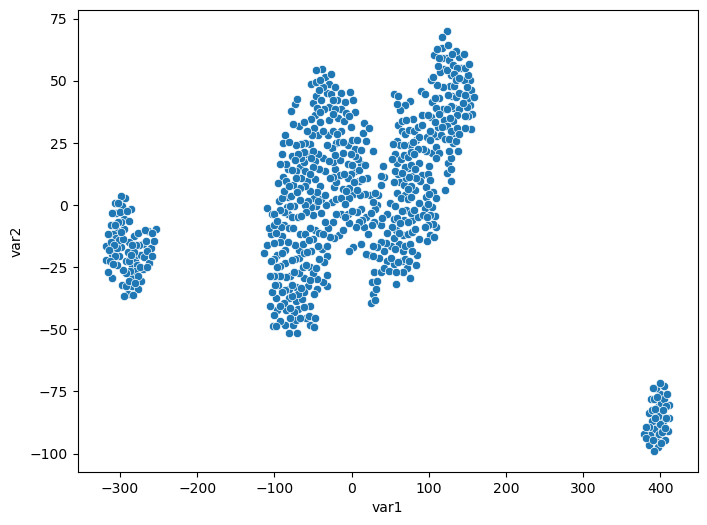

In [61]:
#t-SNE and see how much time it takes (Perplexity=50)
time_start = time.time()

tsne = TSNE(n_components=2,
            init='pca',
            verbose=2, 
            perplexity=50, 
            n_iter=1000,
            learning_rate='auto',
            random_state=0)

tsne_results = tsne.fit_transform(df_t)

print(f't-SNE done! Time elapsed: {time.time()-time_start} seconds.')

#visualise the result in low-dimension (2-dim)
tsne_embedding = pd.DataFrame()
tsne_embedding['var1'] = tsne_results[:,0]
tsne_embedding['var2'] = tsne_results[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    x="var1", y="var2",
    palette=sns.color_palette("hls", 10),
    data=tsne_embedding,
    legend="full",
    alpha=1
)